In [1]:
from scipy.fftpack import dctn, idctn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
from utilities import show_heat_map

In [2]:
# UTILS 
def dct_variance(d,mask):
    '''input: d (dct of the block), mask (0 1 array, non null coefficient) output: variance of the block'''
    d = d*mask
    d = d*d
    return np.sum(d)/np.sum(mask)


def create_mask(k,T):
    mask = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            if (i+j!=0 and i+j<T):
                mask[i,j]=1
    return mask

def process_result(elem,mask,f_var):
    elem.sort(key=lambda el: el[1]) #sort blocks according to their variance
    mask = 1-mask
    mask[0,0]=0
    m = np.zeros_like(mask)
    mean = 0
    n_g = int(len(elem)*f_var)
    if n_g<1:
        return None,None
    for i in range(n_g):
        mean += elem[i][0][0,0]
        m += (elem[i][0]*mask)**2
    d= m/(n_g)
    k = 8
    mean= mean/(n_g)/k

    var_list = []
    for i in range(k):
        for j in range(k):
            if mask[i,j]:
                var_list.append(d[i,j])
    return mean, np.sqrt(np.median(np.array(var_list)))
    



def sliding_mean(arr, p=4):
    L =[sum(arr[:p])/p]
    for i in range(len(arr)-p):
        L.append( (L[-1]*p+arr[p+i]-arr[i])/p)
    return L


# Uniform Noise

(849, 1280)

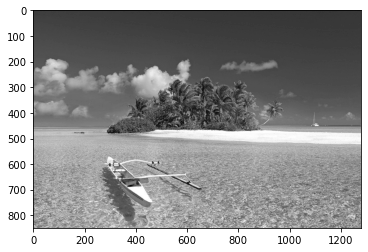

In [4]:
im = np.array(Image.open("paysages/beach.jpg"))
im = np.array(im).mean(axis=2) # convert to bw
plt.imshow(im, cmap='gray')
im.shape

In [5]:
# PONA uniform



def find_uniform_std(arr, k=8, T=8, stride=8):
    n,m = arr.shape
    L=[]
    mask = create_mask(k,T)

    for i in range(0,n-k,stride):
        for j in range(0,m-k,stride):
            dm = dctn(arr[i:i+k,j:j+k],norm='ortho')
            L.append((dm, dct_variance(dm,mask)))
    return process_uni_result(L,mask)

def process_uni_result(L,mask):
    L.sort(key=lambda el: el[1]) #sort blocks according to their variance
    mask = 1-mask
    mask[0,0]=0
    m = np.zeros_like(mask)
    n_g = int(len(L)*0.005)
    for i in range(n_g):
        m += (L[i][0]*mask)**2
    d= m/(n_g)

    k = 8
    var_list = []
    for i in range(k):
        for j in range(k):
            if mask[i,j]:
                var_list.append(d[i,j])
    return np.sqrt(np.median(np.array(var_list)))

im = np.array(Image.open("paysages/beach.jpg"))
im = np.array(im).mean(axis=2) # convert to bw
im += 110*np.random.normal(size=im.shape)
L = find_uniform_std(im)
L

106.8209185117776

# ESTIMATE IMAGE NOISE

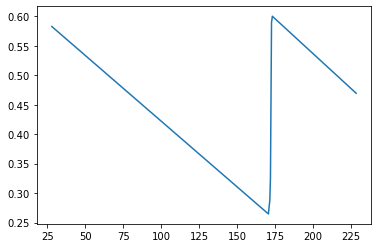

In [6]:
%matplotlib inline  

def create_bins(L, e_per_bin, mask,f_var):
    number_of_bins = int(len(L)/e_per_bin)

    if len(L)/e_per_bin%1==0:
        number_of_bins-=1
    means=[]
    estimates=[]
    for k in range(number_of_bins+1):
        mean, noise_est = process_result(L[k*e_per_bin:min((k+1)*e_per_bin, len(L))], mask, f_var)
        if mean!=None:
            means.append(mean)
            estimates.append(noise_est)
    return means, estimates

def find_value_std(arr, k=8, T=8, stride=1, e_per_bin=10000, f_var=0.005):
    ''' k: patch size
        T: selected low-frequencies in the kxk array
        stride: patch stride
        e_per_bin: elements per bin
        f_var: percentage of patchs used to estimate the variance
        '''
    n,m = arr.shape
    list_dct=[]
    mask = create_mask(k,T)

    for i in range(0,n-k,stride):
        for j in range(0,m-k,stride):
            dm = dctn(arr[i:i+k,j:j+k],norm='ortho')
            list_dct.append((dm, dct_variance(dm,mask))) # block/variance/mean
    list_dct.sort(key=lambda el: el[0][0,0]) #sort blocks according to their mean
    return create_bins(list_dct, e_per_bin, mask,f_var)

im = np.array(Image.open("forged_images/cyg.png"))
im = np.array(im).mean(axis=2) # convert to bw

# im += 110*np.random.normal(size=im.shape)

L = find_value_std(im, f_var=0.005, stride=1, e_per_bin=40000)
plt.plot(L[0],L[1])

# ESTIMATE IMAGE NOISE (histogram)

In [3]:
%matplotlib inline  


def process_bins(list_dct, mask,f_var):
    bins = [0 for i in range(len(list_dct))]
    for i in range(len(list_dct)):
        list_dct[i].sort(key=lambda el: el[1]) #sort blocks according to their variance
        mean, noise_est = process_result(list_dct[i], mask, f_var)
        
        if mean!=None:
            bins[i]=noise_est
           
    return bins

def find_noise_hist(arr, k=8, T=8, stride=1, f_var=0.005, n_bins=50):
    ''' k: patch size
        T: selected low-frequencies in the kxk array
        stride: patch stride
        n_bins: number of bins
        f_var: percentage of patchs used to estimate the variance
        '''
    n,m = arr.shape
    list_dct=[[] for i in range(n_bins)]
    mask = create_mask(k,T)

    for i in range(0,n-k,stride):
        for j in range(0,m-k,stride):
            dm = dctn(arr[i:i+k,j:j+k],norm='ortho')
            try:
                index = int(np.floor(dm[0,0]/k/255*(n_bins-1)))
                list_dct[index].append((dm, dct_variance(dm,mask))) # block/variance/mean

            except:
                print(arr[i:i+k,j:j+k])
                print(dm[0,0])
                return []
            # print(index)
    return process_bins(list_dct, mask,f_var)

# im = np.array(Image.open("forged_images/cyg.png"))
# im = np.array(im).mean(axis=2) # convert to bw
# bins = find_noise_hist(im, f_var=0.005, stride=1)
# plt.plot(bins,'o')

# ESTIMATE PATCH NOISE

In [24]:
def estimate_patch_noise(patch_dct,mask):
    mask = 1-mask
    mask[0,0]=0
    m = (patch_dct*mask)**2
    return np.sqrt(np.sum(m)/np.sum(mask))


def find_patch_std(img, k=8, T=8):
    n,m = img.shape
    L=[]
    mask = create_mask(k,T)
    noise_estimate = np.zeros((n-k,m-k))
    dct_var = np.zeros((n-k,m-k))

    for i in range(0,n-k):
        for j in range(0,m-k):
            dm = dctn(img[i:i+k,j:j+k],norm='ortho')
            dct_var[i,j] = dct_variance(dm,mask)
            noise_estimate[i,j] = estimate_patch_noise(dm,mask)
    return noise_estimate, dct_var

def custom_mean(arr, k=8):
    n,m = arr.shape
    mean = np.zeros((n-k,m-k))
    for i in range(0,n-k):
        for j in range(0,m-k):
            me = np.mean(arr[i:i+k,j:j+k])
            mean[i,j] = me
    return mean


In [26]:

img= np.array(Image.open("forged_images/cyg.png")).astype('float')
img = np.array(img).mean(axis=2)
noise_estimate, dct_var = find_patch_std(img)
cust_m = custom_mean(img)

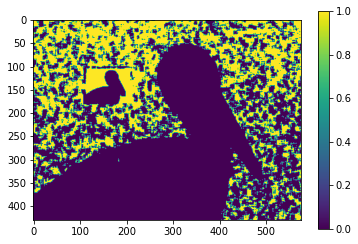

In [27]:
# filter=1
# std_r=skimage.measure.block_reduce(noise_estimate/np.sqrt(cust_m)*np.exp(-dct_var), (filter,filter), np.mean)
plt.imshow(dct_var<1)
plt.colorbar()

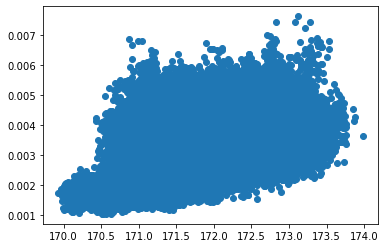

In [28]:
nois_r = noise_estimate*np.exp(-dct_var)/cust_m
filter=8
std_r=skimage.measure.block_reduce(nois_r, (filter,filter), np.mean)
# plt.imshow(std_r)

Lx=[]
Ly=[]
n,m = noise_estimate.shape
for i in range(n):
    for j in range(m):
        if dct_var[i,j]<1 and cust_m[i,j]<200:
            Ly.append(noise_estimate[i,j]/(cust_m[i,j]))
            Lx.append(cust_m[i,j])
plt.plot(Lx,Ly,'o')
plt.show()

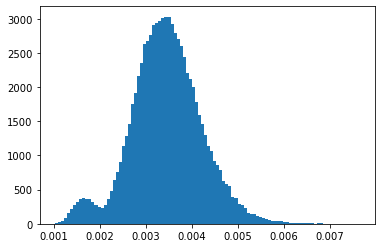

In [29]:
plt.hist(Ly,bins=100)
plt.show()

# 2021 Morel

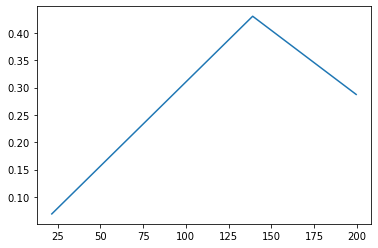

In [11]:
im = np.array(Image.open("forged_images/3.png"))
im = np.array(im).mean(axis=2) # convert to bw
L = find_value_std(im, f_var=0.005, stride=3, e_per_bin=20000)
plt.plot(L[0],L[1])
plt.show()


# im = np.array(Image.open("forged_images/beach_eagle.jpg"))
# im = np.array(im).mean(axis=2) # convert to bw
# L = find_value_std(im, f_var=0.005, stride=4, e_per_bin=20000)
# plt.plot(L[0],L[1])
# plt.show()

24 24
0 % done
4 % done
8 % done
12 % done
17 % done
21 % done
25 % done
30 % done
34 % done
38 % done
42 % done
47 % done
51 % done
55 % done
60 % done
64 % done
68 % done
72 % done
77 % done
81 % done
85 % done
90 % done
94 % done
98 % done
575 575


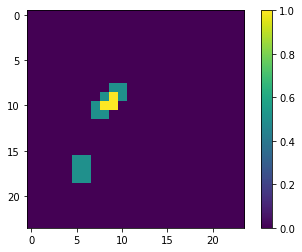

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def compare_noise_curves(L,L_ref):
    '''returns fraction of elements smaller than L_ref'''
    nwrong=0 # number of elements smaller than in ref
    for i in range(len(L[0])):
        if L[0][i]!=-1:
            ref_index = find_nearest(L_ref[0],L[0][i])
            if ref_index!=1 and (L_ref[0][ref_index]-L[0][i])<20:
                if L_ref[1][ref_index]>L[1][i]:
                    nwrong+=1
    return nwrong/len(L[0])

def find_patch_std(img, img_curve, patch_size=128):
    n,m = img.shape
    step =  int(patch_size*0.5)
    new_n = int(n/step)-1
    new_m = int(m/step)-1
    print(new_n,new_m)

    percent_wrong = np.zeros((new_n,new_m))

    for i in range(0,n-patch_size,step):
        print( int(100*i/(n-patch_size)), "% done" )
        for j in range(0,m-patch_size, step):
            new_curve = find_value_std(img[i:i+patch_size,j:j+patch_size], e_per_bin=1000, f_var=0.1)
            percent_wrong[i//step,j//step]=compare_noise_curves(new_curve,img_curve)
    print(i,j)
    return percent_wrong


L2 = find_patch_std(im,L, patch_size=50)
plt.imshow(L2)
plt.colorbar()

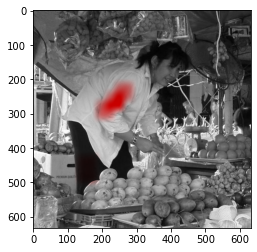

In [13]:

plt.imshow(show_heat_map(im,L2))
plt.imsave('ret2.jpg',show_heat_map(im,L2))

# Histogram approach

In [83]:
# im = np.array(Image.open("forged_images/cyg.png"))
# im = np.array(im).mean(axis=2) # convert to bw
# bins = find_noise_hist(im, f_var=0.005, stride=1, n_bins=50)

im = np.array(Image.open("forged_images/beach_eagle2.jpg"))
im = np.array(im).mean(axis=2) # convert to bw
bins = find_noise_hist(im, f_var=0.005, stride=1, n_bins=50)

In [84]:
def bin_smoothing(bins,k):
    nbins = [0 for i in range(k//2-1)] + bins + [0 for i in range(k//2)]
    return sliding_mean(nbins,k)
sbins =  bin_smoothing(bins,10)

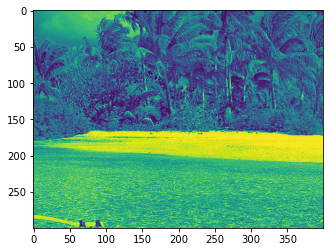

In [85]:
im_crop = im[300:600,400:800]
plt.imshow(im_crop)

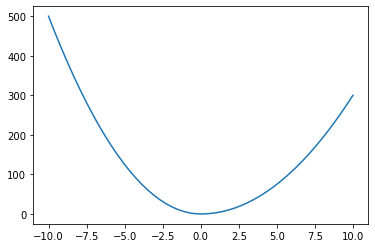

In [86]:
def compare(diff):
    return (diff)**2*(4-np.sign(diff))

t = np.linspace(-10,10)
plt.plot(t,compare(t))
            

32 50
0 % done
3 % done
6 % done
9 % done
12 % done
15 % done
18 % done
21 % done
25 % done
28 % done
31 % done
34 % done
37 % done
40 % done
43 % done
46 % done
50 % done
53 % done
56 % done
59 % done
62 % done
65 % done
68 % done
71 % done
75 % done
78 % done
81 % done
84 % done
87 % done
90 % done
93 % done
96 % done


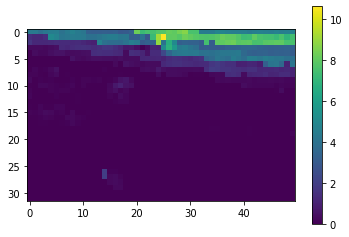

In [89]:
def histogram_score(bins,bins_ref):
    c=0
    m=0
    for i in range(len(bins)):
        if bins[i]!=0:
            diff = bins[i]-bins_ref[i]
            if diff<0:
                c+= (diff)**2
            m+=1
    if m==0:
        return 0
    return c

def find_patch_hist(img, bins_ref, patch_size=128):
    n,m = img.shape
    step =  int(patch_size*0.5)
    new_n = int(n/step)-1
    new_m = int(m/step)-1
    print(new_n,new_m)

    percent_wrong = np.zeros((new_n,new_m))

    for i in range(0,n-patch_size,step):
        print( int(100*i/(n-patch_size)), "% done" )
        for j in range(0,m-patch_size, step):
            bins = find_noise_hist(img[i:i+patch_size,j:j+patch_size], n_bins=len(bins_ref), f_var=0.1)
            percent_wrong[i//step,j//step]=histogram_score(bins,bins_ref)
    return percent_wrong


L2 = find_patch_hist(im,sbins, patch_size=50)
plt.imshow(L2)
plt.colorbar()

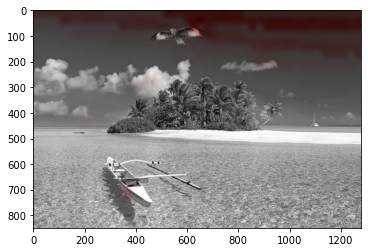

In [90]:
plt.imshow(show_heat_map(im,L2/np.max(L2)))
plt.imsave('ret.jpg',show_heat_map(im,L2/np.max(L2)))

# TEST

In [213]:
%matplotlib qt
def show_hi_freq(arr, k=8, T=8, stride=8):
    n,m = arr.shape
    mask = create_mask(k,T)
    mask[0,0]=1
    narr=arr.copy()
    for i in range(0,n-k,k):
        for j in range(0,m-k,k):
            dm = dctn(arr[i:i+k,j:j+k],norm='ortho')
            dm2 = dm*(1-mask)
            narr[i:i+k,j:j+k] = idctn(dm2 ,norm='ortho')/(np.sqrt(dm[0,0])+0.0001)
    narr = narr[:k*((n-1)//k),:k*((m-1)//k)]
    return narr


def reduce(im, n=1, filter=2):
    for _ in range(n): 
        im=skimage.measure.block_reduce(im, (filter,filter), np.mean)
        im=skimage.measure.block_reduce(im, (filter,filter), np.max)
    return im

im = np.array(Image.open("forged_images/forest_rhino.jpg"))
im = np.array(im).mean(axis=2) # convert to bw
im2 = show_hi_freq(im, 8, 12)
filter=4
im2=skimage.measure.block_reduce(im2, (filter,filter), np.max)
im2=skimage.measure.block_reduce(im2, (filter,filter), np.max)
im2=skimage.measure.block_reduce(im2, (filter,filter), np.max)

# im2=reduce(im2, 2)
im2 -= np.min(im2)
im2 /= np.max(im2)
plt.imshow(im2)
plt.show()
plt.colorbar()

1.0